# Trial Notebook for XCast Pac Islands
Trial notebook to test out seasonal predictions using Xcast, modifying subseaonal scripts that Endalk wrote for Caribbean

## Libraries

In [57]:
import xcast as xc
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

#functions, constants, created in same folder
import xcast_season_config as cfg

#to import functions from another folder
import importlib.util
# passing the file name and path as argument
spec = importlib.util.spec_from_file_location(
  "helper_functions", "/cpc/int_desk/pac_isl/analysis/helper_functions.py")  

spec2 = importlib.util.spec_from_file_location(
  "helper_dictionaries", "/cpc/int_desk/pac_isl/analysis/helper_dictionaries.py")    
hdict = importlib.util.module_from_spec(spec2) 
spec2.loader.exec_module(hdict)

# importing the module as helper
helper = importlib.util.module_from_spec(spec) 
spec.loader.exec_module(helper)

# automatically reloads the configuration file once updated and saved so you don't have to restart the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read / Prepare Seasonal Data

In [55]:
#define hindcast years
hcst_years = helper.getYears(cfg.hstart,cfg.hend)

#read in obs data for all seasons 
chirps_hcst = xr.open_dataset(os.path.join(cfg.chirps_dir, 'chirps05_pac-islands'))

#calculate initialized month
current_month = 5 #datetime.today().month --- uncomment this to make more operational

#read in model data, observed data for all lead times
nmme_mme_hcsts, nmme_mme_fcsts, chirps_hcsts = [], [], []
seasons_to_plot = []
for l in cfg.leads:
    nmme_mme_hcsts.append(xr.open_dataset(os.path.join(cfg.nmme_dir, 'nmme_hind_precip_ld' + str(l) + '.nc')))
    nmme_mme_fcsts.append(xr.open_dataset(os.path.join(cfg.nmme_dir, 'nmme_fcst_precip_ld' + str(l) + '.nc')))
    seas = helper.calc_season_name_from_month_lead(current_month, l)#calculate season of interest
    seasons_to_plot.append(seas)
    chirps_hcsts.append(chirps_hcst.sel(season=seas))
nmme_mme_hcsts = xr.concat(nmme_mme_hcsts, dim = 'L')
nmme_mme_fcsts = xr.concat(nmme_mme_fcsts, dim = 'L')
chirps_hcsts = xr.concat(chirps_hcsts, dim = 'L')

nmme_hcst_360 = helper.adjust_longitude_to_360(nmme_mme_hcsts, 'lon').sortby('lat', ascending = False).sortby('lon', ascending = True)
nmme_fcst_360 = helper.adjust_longitude_to_360(nmme_mme_fcsts, 'lon').sortby('lat', ascending = False).sortby('lon', ascending = True)

#select over a large predictor zone relevant for pac islands
nmme_hcst_pacisl = nmme_hcst_360.sel(lon = slice(cfg.predictor_w, cfg.predictor_e),
                               lat = slice(cfg.predictor_n, cfg.predictor_s))
nmme_fcst_pacisl = nmme_fcst_360.sel(lon = slice(cfg.predictor_w, cfg.predictor_e),
                               lat = slice(cfg.predictor_n, cfg.predictor_s))
#select only years in model hindcast period
chirps_years = chirps_hcsts.sel(year = chirps_hcsts.year.isin(hcst_years))
chirps_years = chirps_years.rename({'longitude':'lon', 'latitude':'lat'}).sortby('lon', ascending=True)

#modify all coordinates to 360' grid
chirps_360 = helper.adjust_longitude_to_360(chirps_years, 'lon').sortby('lat', ascending = False).sortby('lon', ascending = True)
chirps_pacisl = chirps_360.sortby('lon', ascending=True).sel(lon = slice(cfg.predictand_w, cfg.predictand_e),
                              lat = slice(cfg.predictand_n, cfg.predictand_s))

## Trialling Out XCast CCA

In [78]:
cca_fcsts_prob, cca_fcsts_det, cca_hcasts_det, cca_hcasts_prob = [],[],[],[]
pearson_cca = []
for l in cfg.leads:
    #select lead
    model1 = nmme_hcst_pacisl.isel(L=(l-1))
    obs1 = chirps_pacisl.isel(L=(l-1))
    fmodel1 = nmme_fcst_pacisl.isel(L=(l-1))
    
    #expand dims to include an 'M' to make xcast work
    model = model1.precip.expand_dims({'M':[0]})
    fmodel = fmodel1.precip.expand_dims({'M':[0]})
    obs1 = obs1.precip.expand_dims({'M':[0]})
    
    #update observations to have same time dimension as the model hindcasts
    obs = []
    for t, y in enumerate(np.unique(obs1.year.values)):
        obs_year = obs1.sel(year=y)
        obs_year = obs_year.assign_coords({'time': model.isel(time=t).time.values})
        obs.append(obs_year)
    obs = xr.concat(obs, dim = 'time')
    obs = obs.drop(['year', 'season'])#no need to drop to make it work, just don't need these now

    #mask missing
    # mask_missing = model.mean('time', skipna=False).mean('M', skipna=False)
    # mask_missing = xr.ones_like(mask_missing).where(~np.isnan(mask_missing), other=np.nan)
    # model = model * mask_missing

    # mask_missing = obs.mean('time', skipna=False).mean('M', skipna=False)
    # mask_missing = xr.ones_like(mask_missing).where(~np.isnan(mask_missing), other=np.nan)
    # obs = obs * mask_missing
    # ohc = xc.OneHotEncoder()
    
    
    #run CCA
    hindcasts_det, hindcasts_prob = [], []
    i=1
    for xtrain, ytrain, xtest, ytest in xc.CrossValidator(model, obs, window=cfg.lov_window):
        print("window {}".format(i))
        i += 1
        reg = xc.CCA(search_override=(cfg.x_modes,
                                      cfg.y_modes,
                                     cfg.cca_modes))
        reg.fit(xtrain, ytrain)
        preds = reg.predict(xtest)
        probs =  reg.predict_proba(xtest)
        hindcasts_det.append(preds)
        hindcasts_prob.append(probs)
    hindcasts_det = xr.concat(hindcasts_det, 'time')
    hindcasts_prob = xr.concat(hindcasts_prob, 'time')
    
    fprobs =  reg.predict_proba(fmodel)
    #to check the forecast ran, quick plot
    #fBN_plot = fprobs.sel(M='BN').plot()
    #plt.show()

    #calculate pearson correlation score for hindcasts
    pearson_calc = xc.Pearson(hindcasts_det, obs)
    pearson_cca.append(pearson_calc)
    #pearson_plot = pearson_calc.plot(vmin=-1,vmax=1, levels = 21, cmap='coolwarm')
    #plt.show()

    cca_fcsts_prob.append(fprobs)
    cca_hcasts_det.append(hindcasts_det)
    cca_hcasts_prob.append(hindcasts_prob)
cca_fcsts_prob = xr.concat(cca_fcsts_prob, dim = 'L')
cca_hcasts_det = xr.concat(cca_hcasts_det, dim = 'L')
cca_hcasts_prob = xr.concat(cca_hcasts_prob, dim = 'L')
pearson_cca = xr.concat(pearson_cca, dim = 'L')

window 1
window 2
window 3
window 4
window 5
window 6
window 7
window 8
window 9
window 10
window 11
window 12
window 13
window 14
window 15
window 16
window 17
window 18
window 19
window 20
window 21
window 22
window 23
window 24
window 25
window 26
window 27
window 28
window 29
window 30
window 31
window 32
window 1
window 2
window 3
window 4
window 5
window 6
window 7
window 8
window 9
window 10
window 11
window 12
window 13
window 14
window 15
window 16
window 17
window 18
window 19
window 20
window 21
window 22
window 23
window 24
window 25
window 26
window 27
window 28
window 29
window 30
window 31
window 32
window 1
window 2
window 3
window 4
window 5
window 6
window 7
window 8
window 9
window 10
window 11
window 12
window 13
window 14
window 15
window 16
window 17
window 18
window 19
window 20
window 21
window 22
window 23
window 24
window 25
window 26
window 27
window 28
window 29
window 30
window 31
window 32


<xarray.DataArray 'predicted_values' (M: 3, time: 1, lat: 100, lon: 120)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * lat      (lat) float32 -15.0

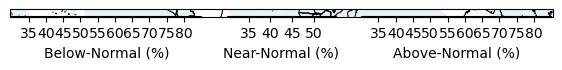

In [94]:
print (cca_fcsts_prob.isel(L=l))
from mprob import mview_probabilistic
mview_probabilistic(cca_fcsts_prob.isel(L=l, time=0))#, title='GEFS, Week-${wk}, S. Weighted Cons., Valid: ${iwk} - ${fwk}', savefig=os.path.join(cfg.output_path,'gefs_week_${wk}_cons.png'))

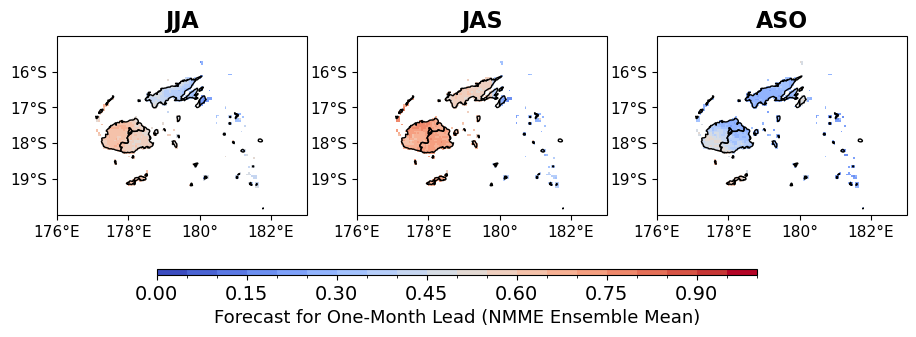

In [92]:
# Create a figure
fig = plt.figure(figsize=(10, 3))

# Iterate over each month and plot the data
for l, lead in enumerate(range(1, 4)):
    #print(month)
    # Add subplot to the figure
    ax = fig.add_subplot(1, 3, l+1, projection=ccrs.PlateCarree(central_longitude=180))

    # Plot data for the current month
    im =cca_fcsts_prob.isel(time=0, L=l, M=0).plot(transform=ccrs.PlateCarree(),
                                              subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},
                                             vmin=0,vmax=1, levels = 21, cmap='coolwarm',add_colorbar=False)
    
    # Set title with season name
    ax.set_title(seasons_to_plot[l], fontsize=16, weight='bold')
    
    # Add features
    ax.add_feature(cf.BORDERS)
    ax.add_feature(cf.STATES)
    # Set the ticks manually
    xticks = [176, 178, 180, 182]
    yticks = [-19,  -18,  -17, -16]
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax.set_xlabel('')
    ax.set_ylabel('')
    # Set the tick labels
    ax.set_xticklabels(['176°E', '178°E', '180°', '182°E'])
    ax.set_yticklabels(['19°S', '18°S', '17°S', '16°S'])
    # Set font size for tick labels
    plt.setp(ax.get_xticklabels(), fontsize=11)
    plt.setp(ax.get_yticklabels(), fontsize=11)
# Adjust layout
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.2, hspace=0.2)
# Add a single horizontal colorbar below the panel plot
cbar_ax = fig.add_axes([0.15, 0.002, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Forecast for One-Month Lead (NMME Ensemble Mean)', fontsize=13)
cbar.ax.tick_params(labelsize=14)

# Show plot
plt.show()

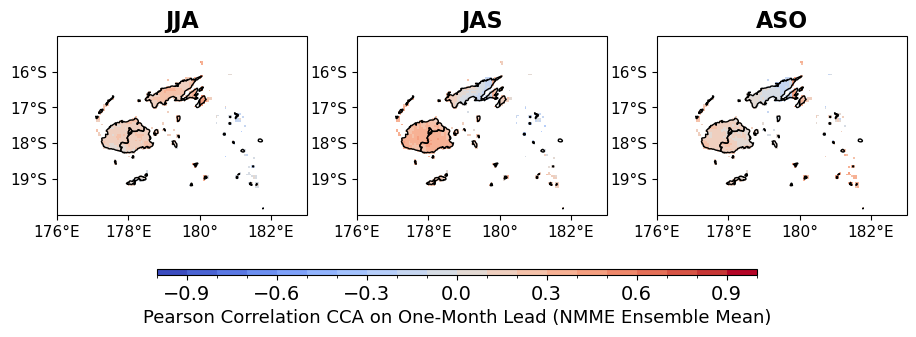

In [73]:
# Create a figure
fig = plt.figure(figsize=(10, 3))

# Iterate over each month and plot the data
for l, lead in enumerate(range(1, 4)):
    #print(month)
    # Add subplot to the figure
    ax = fig.add_subplot(1, 3, l+1, projection=ccrs.PlateCarree(central_longitude=180))

    # Plot data for the current month
    im =pearson_cca.isel(L=l).plot(transform=ccrs.PlateCarree(),
                                              subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},
                                             vmin=-1,vmax=1, levels = 21, cmap='coolwarm',add_colorbar=False)
    # Set title with season name
    ax.set_title(seasons_to_plot[l], fontsize=16, weight='bold')
    
    # Add features
    ax.add_feature(cf.BORDERS)
    ax.add_feature(cf.STATES)
    # Set the ticks manually
    xticks = [176, 178, 180, 182]
    yticks = [-19,  -18,  -17, -16]
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax.set_xlabel('')
    ax.set_ylabel('')
    # Set the tick labels
    ax.set_xticklabels(['176°E', '178°E', '180°', '182°E'])
    ax.set_yticklabels(['19°S', '18°S', '17°S', '16°S'])
    # Set font size for tick labels
    plt.setp(ax.get_xticklabels(), fontsize=11)
    plt.setp(ax.get_yticklabels(), fontsize=11)
# Adjust layout
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.2, hspace=0.2)
# Add a single horizontal colorbar below the panel plot
cbar_ax = fig.add_axes([0.15, 0.002, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Pearson Correlation CCA on One-Month Lead (NMME Ensemble Mean)', fontsize=13)
cbar.ax.tick_params(labelsize=14)

# Show plot
plt.show()

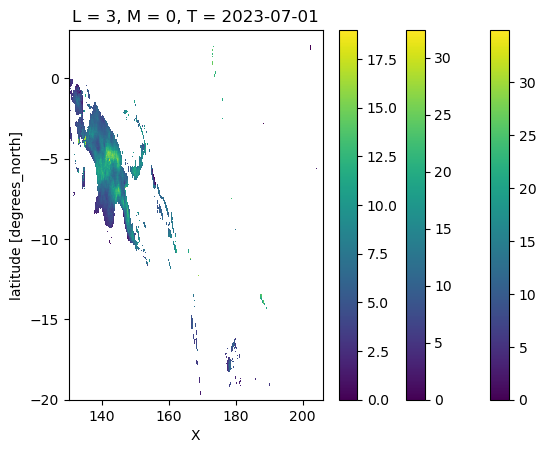

In [3]:
import xcast as xc 
import xarray as xr 
import cartopy.crs as ccrs 
import numpy as np
import matplotlib.pyplot as plt
#import rioxarray
#import geopandas as gpd
#from shapely.geometry import mapping
import datetime as dt
from datetime import datetime
from pathlib import Path
import os
import time
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import glob

#obs_name CMORPH or CHIRPS
obs_name='CHIRPS'

#data directory
ddir='/cpc/int_desk/pac_isl/analysis/xcast/seasonal/practical_notebooks/practical_data'
#shapefile directory
#wdir = '/cpc/int_desk/pac_isl/analysis/xcast/seasonal'
#boundary_dir = os.path.join(wdir, 'pacific_shapefile')

#month dictionary
number_to_month_name_dictionary = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec',
    0: 'Dec'
}

initial_dates = [(2023, 7,1)]
#, (2023, 8, 1), (2023, 9, 1), (2023, 10, 1), (2023, 11,1), (2023, 12,1),(2024, 1, 1), (2024, 2, 1), (2024, 3, 1), (2024, 4, 1), (2024, 5, 1), (2024, 6, 1)]

#generate seasons of interest for initialization dates
initial_months, initial_month_names, target_seasons, target_months = [], [], [], []
 
for i in initial_dates:
    leads = [['1', '3'],['2', '4'], ['3','5']]
    initial_month = dt.datetime(*i).month
    initial_months.append(initial_month)
    initial_month_names.append(number_to_month_name_dictionary[initial_month])
    target_month = []
    target_seas = []
    for l in leads:
        target_low = number_to_month_name_dictionary[(initial_month + float(l[0]))%12]
        target_mid = number_to_month_name_dictionary[(initial_month + float(l[0])+1)%12]
        target_high = number_to_month_name_dictionary[(initial_month + float(l[1]))%12]
        target_seas.append('-'.join([target_low, target_high]))
        target_month.append(target_low[0] + target_mid[0] + target_high[0])
    target_seasons.append(target_seas)
    target_months.append(target_month)

for initial_month_name in initial_month_names:
    #read in observations
    if obs_name == 'CMORPH':
        training_length = 'threeseas'
    elif obs_name == 'CHIRPS':
        training_length = 'oneseas'
    obs_leads = xr.open_dataset(os.path.join(ddir, '_'.join([initial_month_name, training_length, obs_name, 'precip.nc'])))

    #if obs_name == 'CMORPH':
        #obs_leads = obs_leads.rio.set_spatial_dims(x_dim='X', y_dim='Y')
        #obs_leads = obs_leads.rio.write_crs("EPSG:4326")
        #shapefile = gpd.read_file(os.path.join(boundary_dir, 'ppacific.shp'))
        #if shapefile.crs is None:
        #    shapefile.set_crs("EPSG:4326", inplace=True)
        #if shapefile.crs != obs_leads.rio.crs:
        #    shapefile = shapefile.to_crs(obs_leads.rio.crs)
        #masked_obs = obs_leads.rio.clip(shapefile.geometry.apply(mapping), shapefile.crs)
    #elif obs_name == 'CHIRPS':
        #r1_coordinates = {
        #'west':  130,
        #'east': 170,  
        #'north': 1,  
        #'south': -12}
        
        #r2_coordinates = {
        #'west':  170,
        #'east': 203,  
        #'north': 3,  
        #'south': -20}
        
    #masked_obs1 = obs_leads.sel(X=slice(r1_coords['west'], r1_coords['east']),
    #                  Y=slice(r1_coords['south'], r1_coords['north']))
    #masked_obs2 = obs_leads.sel(X=slice(r2_coords['west'], r2_coords['east']),
    #                  Y=slice(r2_coords['south'], r2_coords['north']))
    
    # read in hindcast and forecast data
    hindcast_data = xr.open_dataset(os.path.join(ddir,
    '_'.join([initial_month_name, training_length, 'NMME_hcst_precip.nc'])))
    forecast_data = xr.open_dataset(os.path.join(ddir, '_'.join([initial_month_name, training_length, 'NMME_fcst_precip.nc'])))  
    
    #read in the mask for the data
    msk = xr.open_dataset('/cpc/africawrf/ebekele/projects/PREPARE_pacific/notebooks/masked/libs/pacific_mask.nc')
    mskk = msk.amask.expand_dims({'M':[0]})
    mskk = mskk.assign_coords({'lon': [i + 360 if i <= 0 else i for i in mskk.coords['lon'].values]}).sortby('lon').drop_duplicates('lon')
    mskk = mskk.rename({'lon':'X', 'lat':'Y', 'time':'T'})
    mskk = xc.regrid(mskk, obs_leads.X, obs_leads.Y)
    mask_missing = mskk.mean('T', skipna=False).mean('M', skipna=False)
    mask_missing = xr.ones_like(mask_missing).where(~np.isnan(mask_missing), other=np.nan )
    
    ## run cca
    start_time = time.time()
    cca_fcsts_prob, cca_fcsts_det, cca_hcasts_det, cca_hcasts_prob, obs_to_test = [],[],[],[],[]

    for l in np.unique(hindcast_data.L):
        model = hindcast_data.sel(L=l).precip
        obs = obs_leads.sel(L=l).precip
        fmodel = forecast_data.sel(L=l).precip
        
        obs = obs * mask_missing
        obs.isel(T=0).plot()

In [30]:
ohc = xc.OneHotEncoder() 
ohc.fit(obs.rename({'lat':'Y', 'lon':'X', 'time':'T'}))
#T = ohc.transform(obs)
# clim = xr.ones_like(T) * 0.333
# print(T)
# groc=xc.GROCS(hindcasts_prob1, T)
# pl=xc.view(groc,title='GROCS',cmap=plt.get_cmap('RdBu',8),vmin=0,vmax=1)

TypeError: _nanquantile_dispatcher() got an unexpected keyword argument 'method'

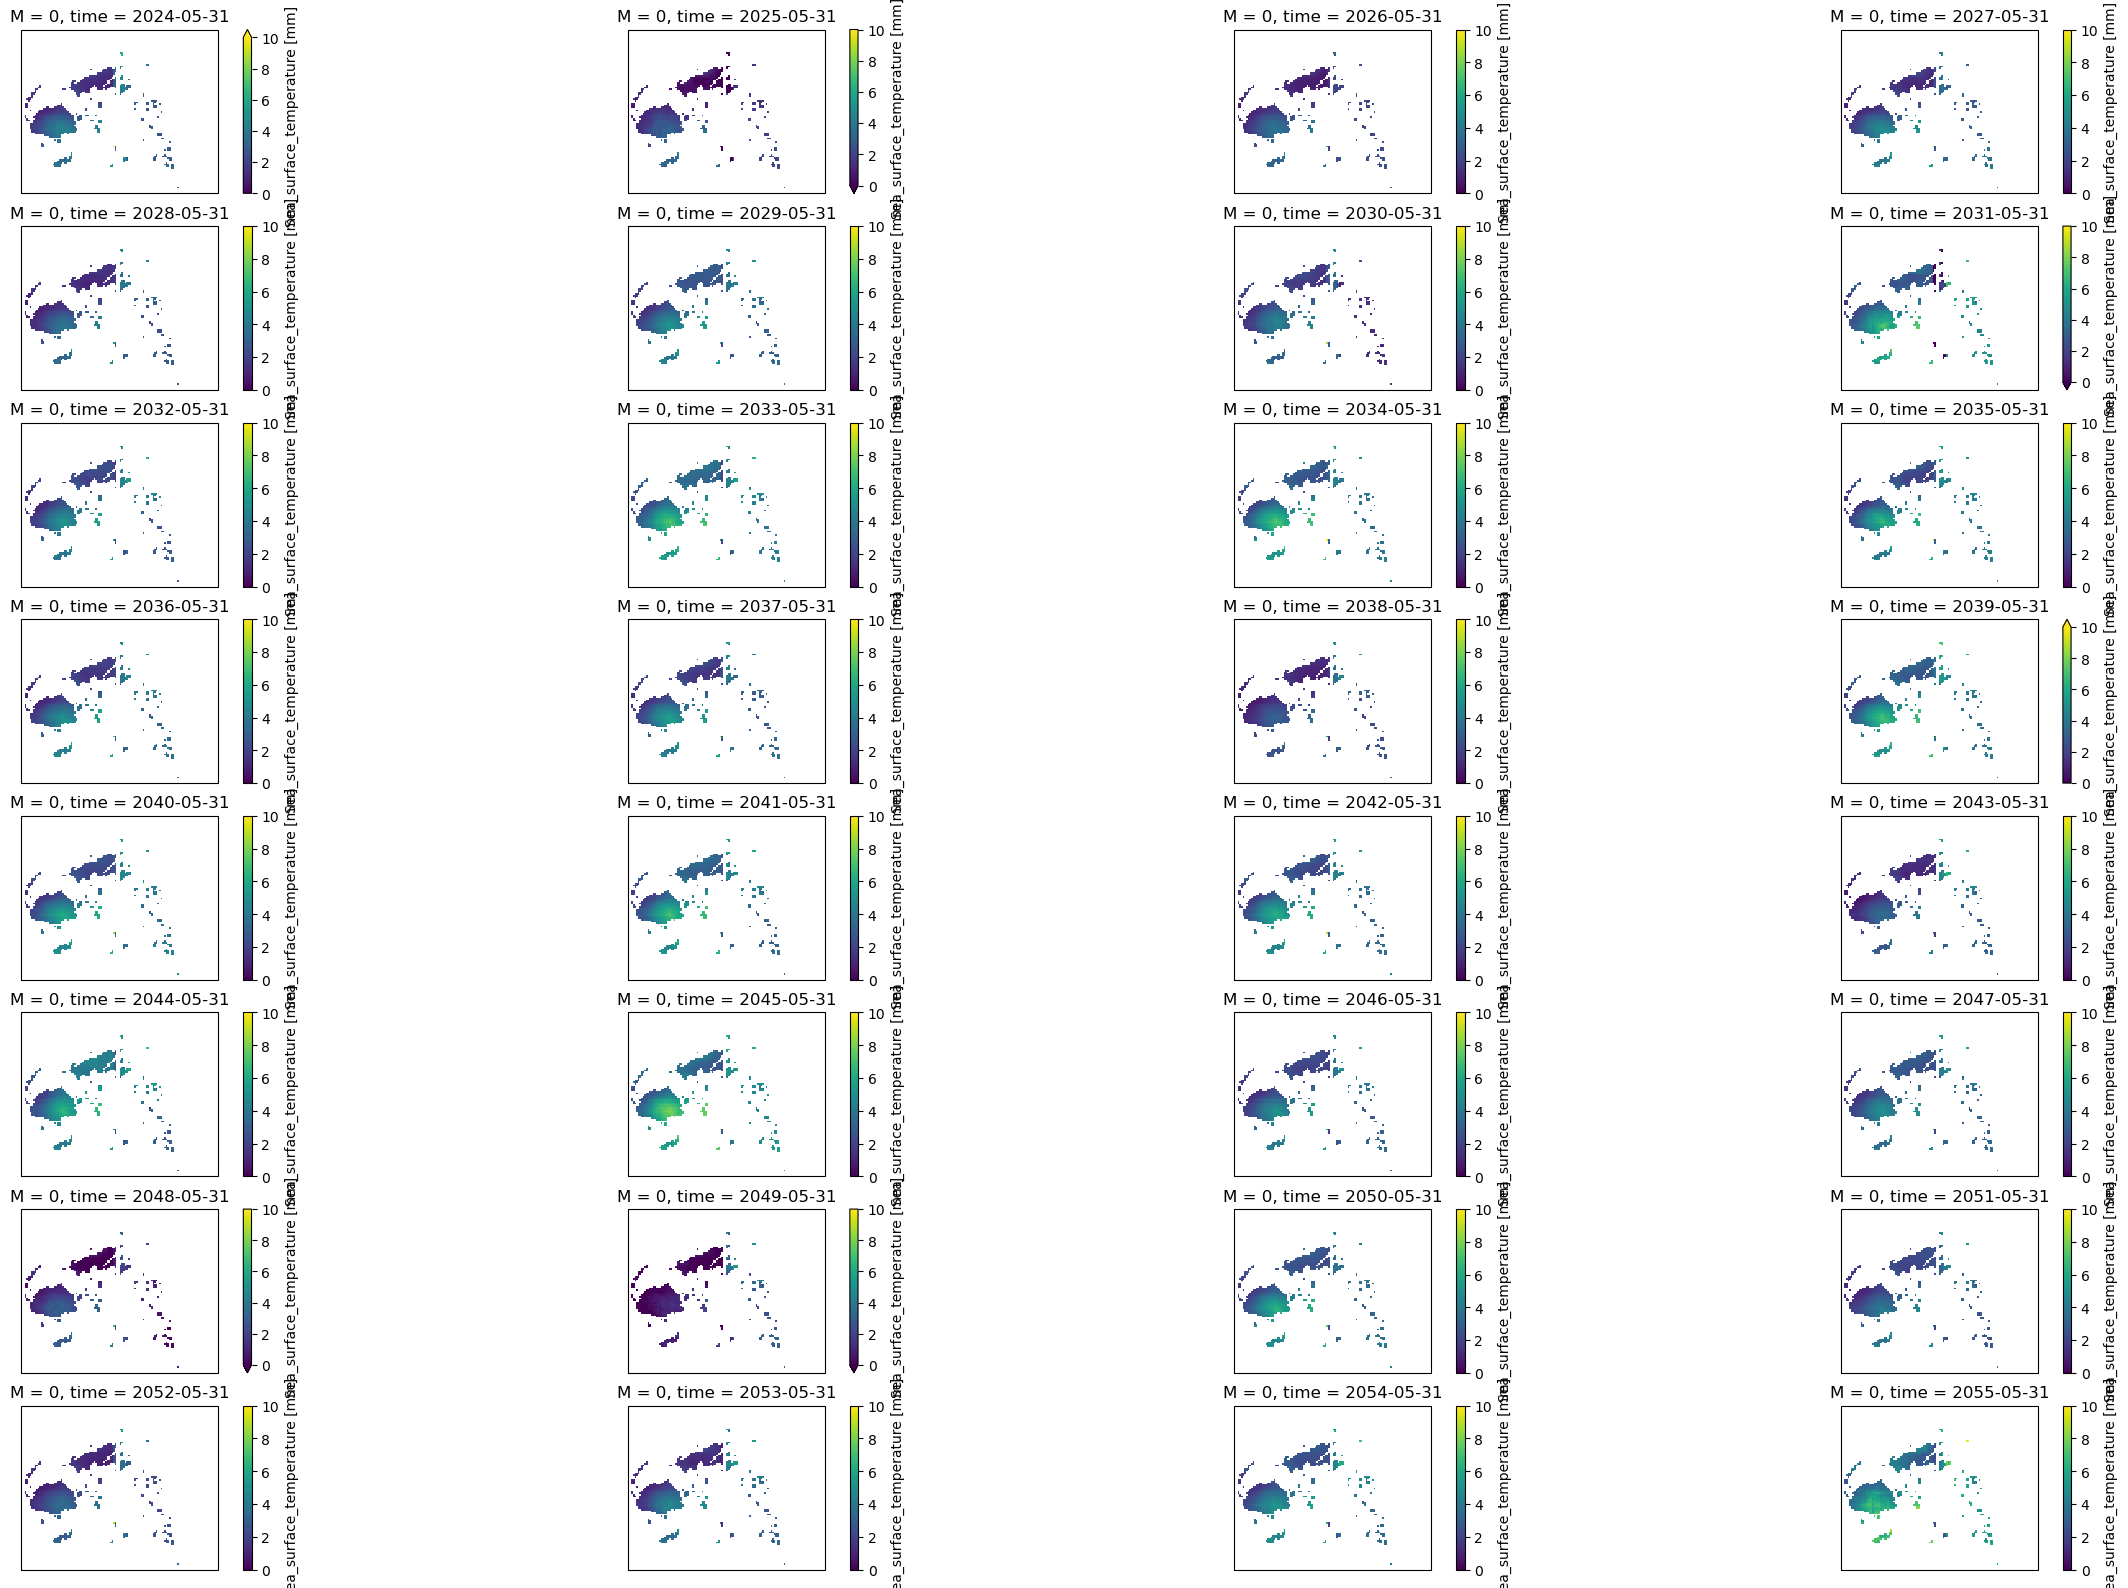

In [115]:
# Create a figure
fig = plt.figure(figsize=(30, 20))

# Iterate over each month and plot the data
for i, month in enumerate(range(1, 33)):
    #print(month)
    # Add subplot to the figure
    ax = fig.add_subplot(8, 4, i+1, projection=ccrs.PlateCarree(central_longitude=180))

    # Plot data for the current month
    im =hindcasts_det1.isel(M=0, time=i).plot(transform=ccrs.PlateCarree(),
                                              subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},
                                             vmin=0,vmax=10)

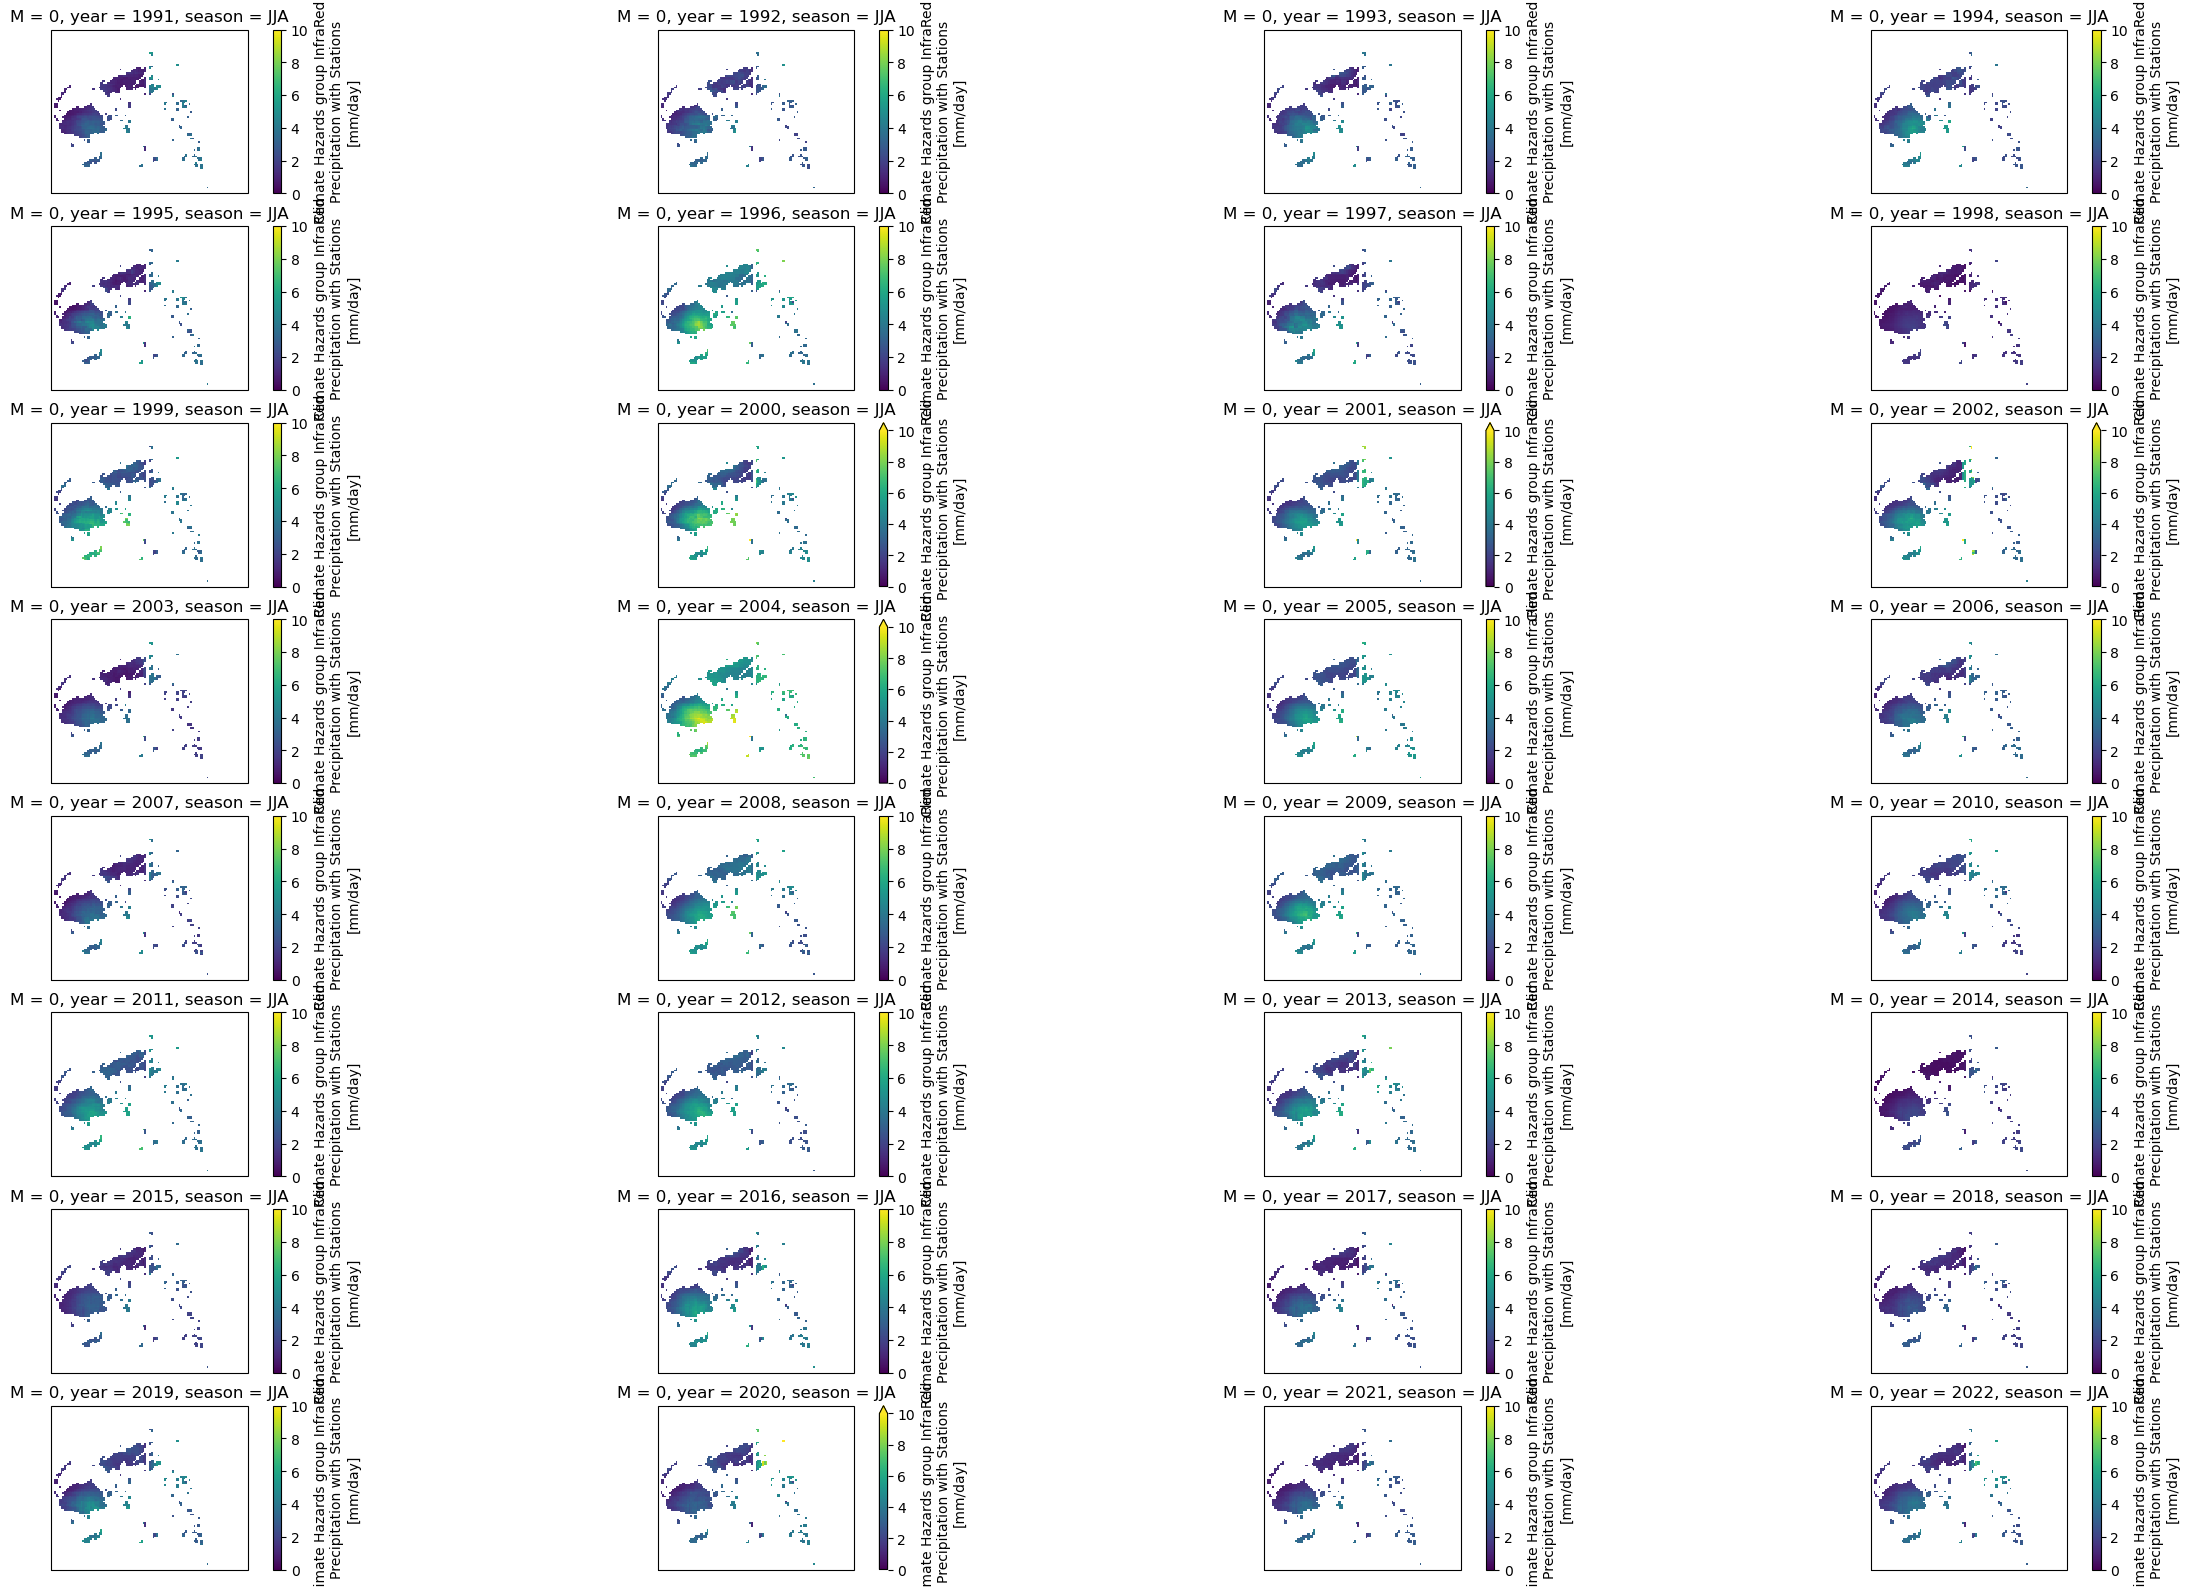

In [116]:
# Create a figure
fig = plt.figure(figsize=(30, 20))

# Iterate over each month and plot the data
for i, month in enumerate(range(1, 33)):
    #print(month)
    # Add subplot to the figure
    ax = fig.add_subplot(8, 4, i+1, projection=ccrs.PlateCarree(central_longitude=180))

    # Plot data for the current month
    im =obs.isel(year=i).plot(transform=ccrs.PlateCarree(),
                                              subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},
                                             vmin=0,vmax=10)

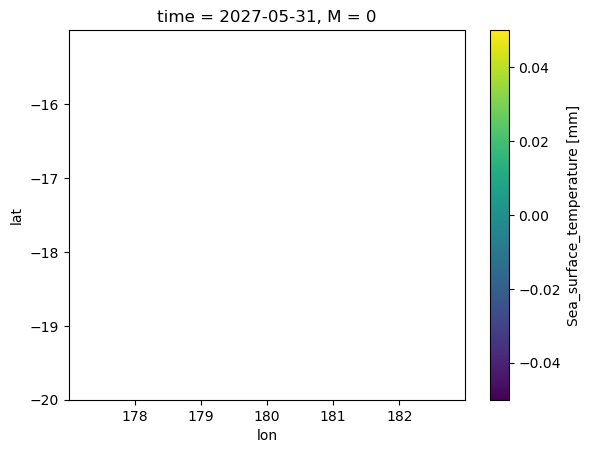

In [60]:
hindcasts_det.isel(M=0,time=3).plot()

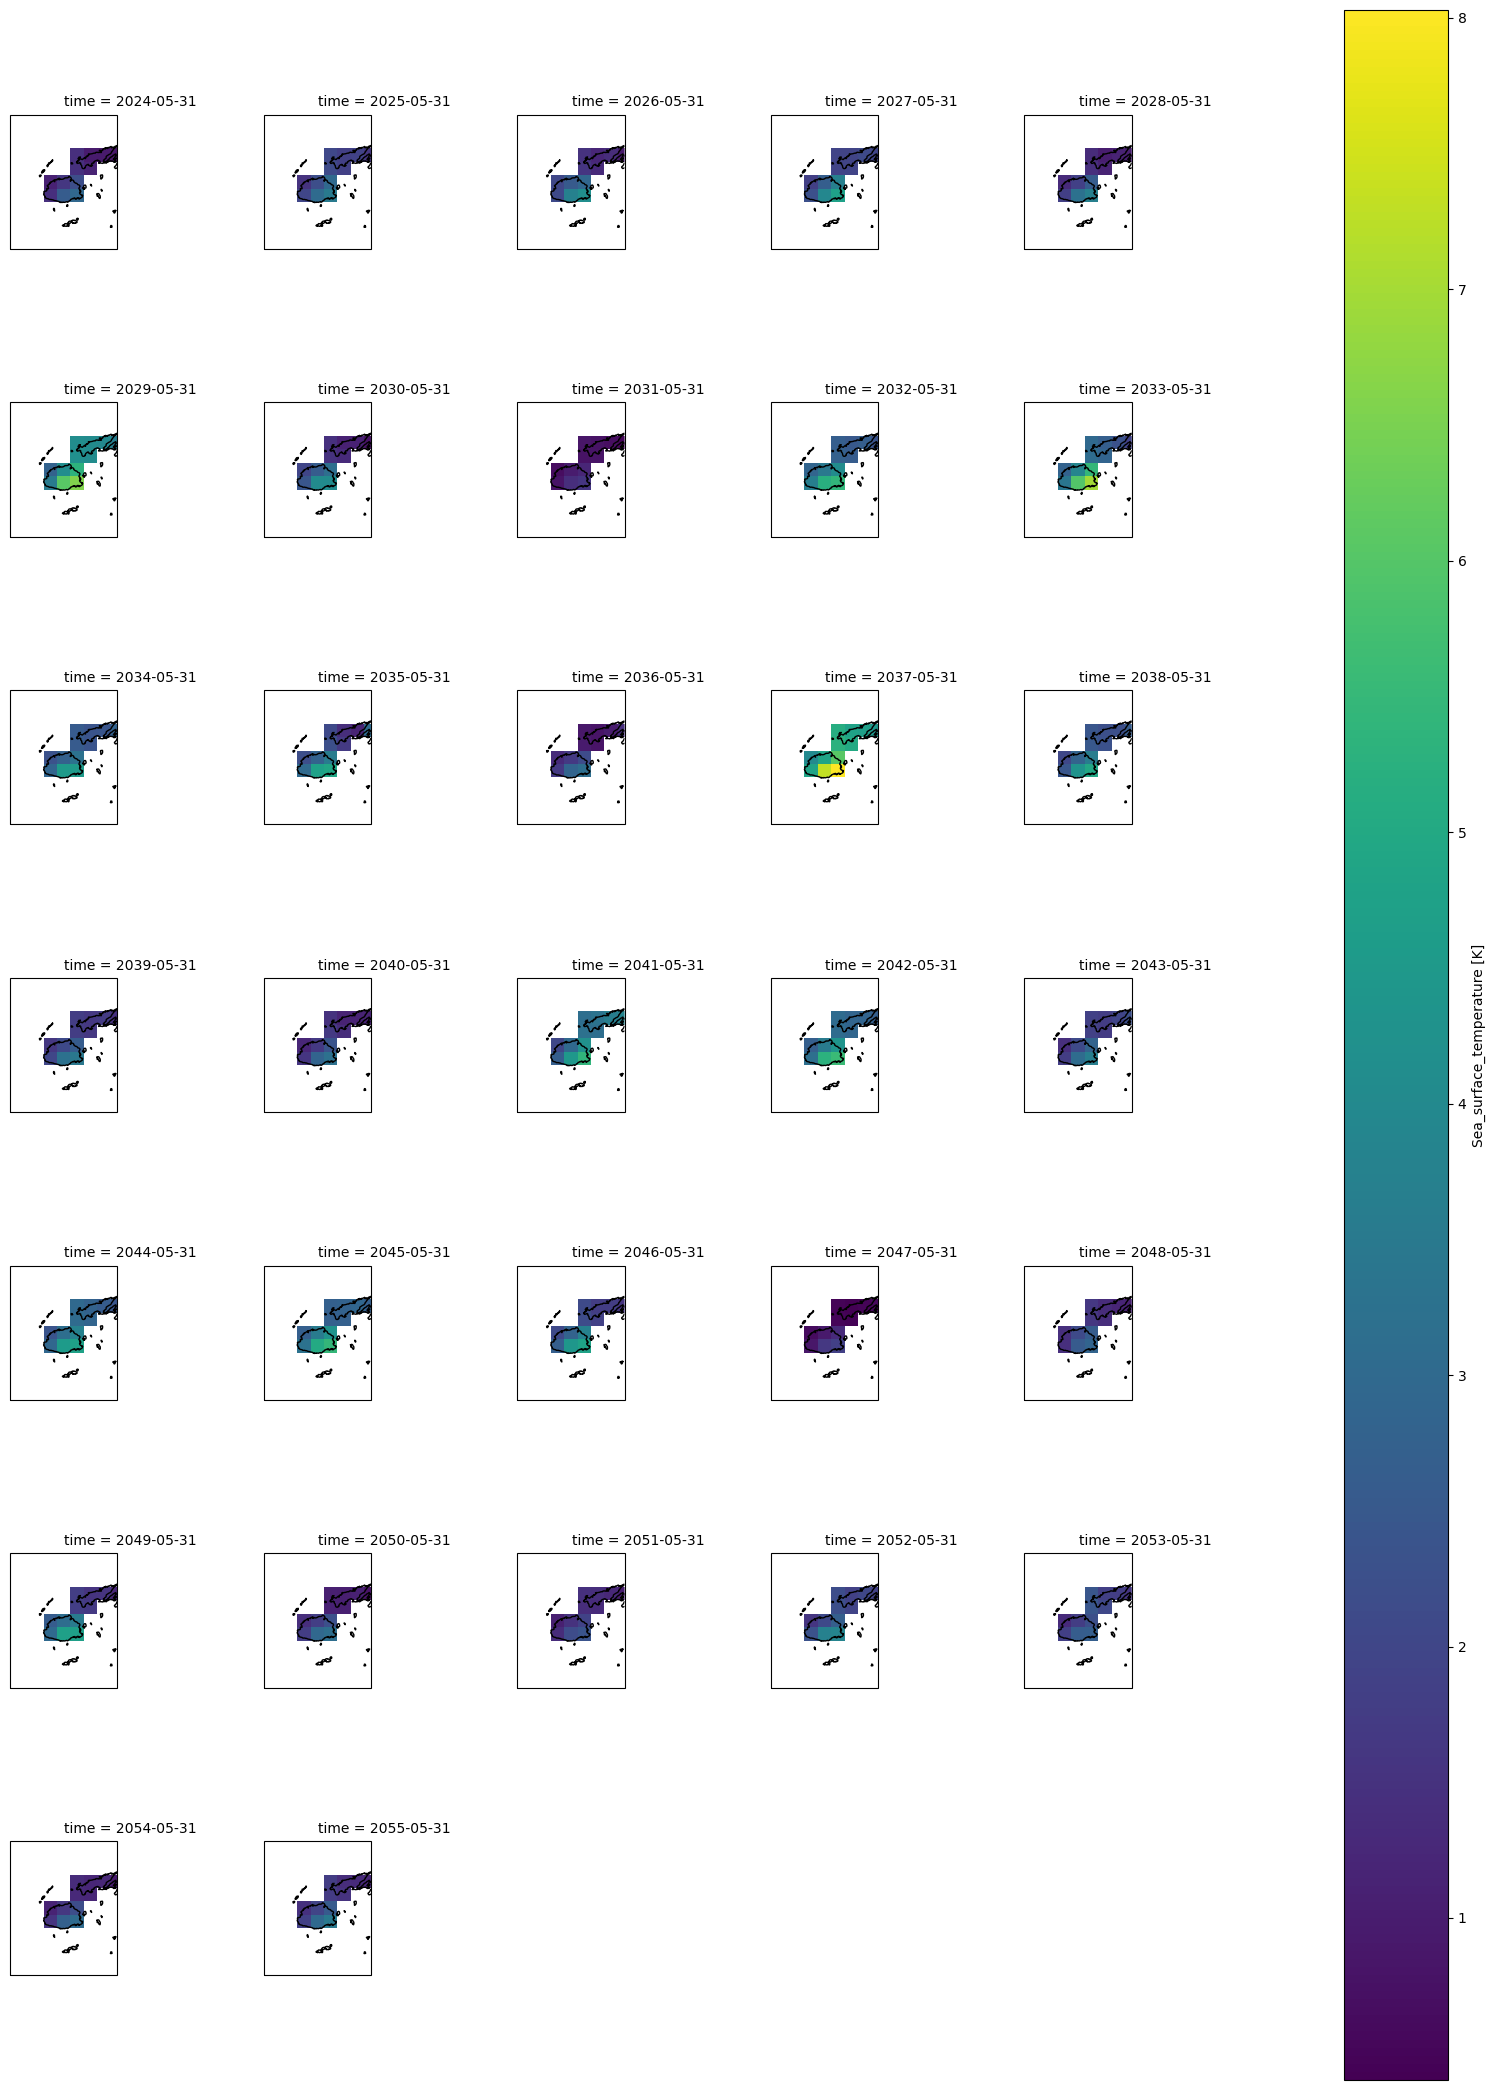

In [105]:
splot = chirps_pacisl.precip.plot(col = 'time', col_wrap = 5,subplot_kws={'projection':ccrs.PlateCarree()})
                                  # (transform.ccrs.PleteCareer(), vmin=0, vmax = 600, levels=21)
#splot = splot.plot(transform.ccrs.PleteCareer(), vmin=0, vmax = 600, levels=21)
for ax in  splot.axs.flat:
    coasts = ax.coastlines()
    ax.set_xlim(pred_w, pred_e)
    ax.set_ylim(pred_s, pred_n)
plt.show()

In [27]:
hmodelt = nmme_mme_hcst.precip.expand_dims({'M':[0]})
fmodelt = nmme_mme_fcst.precip.expand_dims({'M':[0]})
obs = chirps_hcst.precip.expand_dims({'M':[0]})

drymask = xc.drymask(obs, dry_threshold= cfg.dry_threshold)#, quantile_threshold=cfg.quantile_threshold)
obs = obs*drymask
drymask = xc.drymask(hmodelt, cfg.dry_threshold, cfg.quantile_threshold)
modelt = hmodelt*drymask

TypeError: _nanquantile_dispatcher() got an unexpected keyword argument 'method'